## Part 1. Machine Learning

### Sprint 1. Supervised Machine Learning Fundamentals

### Travel Insurance Prediction Data

Data was taken from Kaggle on July, 2023. <br>https://www.kaggle.com/datasets/tejashvi14/travel-insurance-prediction-data

### Description of Data

<b>Age</b> - Age Of The Customer<br>
<b>Employment Type</b> - The Sector In Which Customer Is Employed<br>
<b>GraduateOrNot</b> - Whether The Customer Is College Graduate Or Not<br>
<b>AnnualIncome</b> - The Yearly Income Of The Customer In Indian Rupees[Rounded To Nearest 50 Thousand Rupees]<br>
<b>FamilyMembers</b> - Number Of Members In Customer's Family<br>
<b>ChronicDisease</b> - Whether The Customer Suffers From Any Major Disease Or Conditions Like Diabetes/High BP or Asthama,etc.<br>
<b>FrequentFlyer</b> - Derived Data Based On Customer's History Of Booking Air Tickets On Atleast 4 Different Instances In The Last 2 Years[2017-2019].<br>
<b>EverTravelledAbroad</b> - Has The Customer Ever Travelled To A Foreign Country[Not Necessarily Using The Company's Services]<br>
<b>TravelInsurance</b> - Did The Customer Buy Travel Insurance Package During Introductory Offering Held In The Year 2019.<br>

### Main Objectives

* Create a model to predict the TravelInsurance column using the other features
* Analyze which combination of categorical features of customers purchases the Insurance the most.
* Is there are a significant difference in annual income between graduated and non-graduated people?
* Between which age groups there are and there aren't significant difference in annual income?

#### Importing Required Modules

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objects as go
from imblearn.under_sampling import RandomUnderSampler
import scipy.stats as stats
import scikit_posthocs as sph
from typing import Union
from scipy.stats import chi2_contingency, mannwhitneyu
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    roc_curve,
    auc,
)

import warnings

%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

#### Loading Data

In [2]:
insurance_df = pd.read_csv("TravelInsurancePrediction.csv", index_col=0)

<IPython.core.display.Javascript object>

In [3]:
insurance_df.head(3)

,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,31,Government Sector,Yes,400000,6,1,No,No,0
1,31,Private Sector/Self Employed,Yes,1250000,7,0,No,No,0
2,34,Private Sector/Self Employed,Yes,500000,4,1,No,No,1


<IPython.core.display.Javascript object>

### General Data Check and Cleaning

In [4]:
print(
    f"There are {insurance_df.shape[0]} entries and {insurance_df.shape[1]} features."
)

There are 1987 entries and 9 features.


<IPython.core.display.Javascript object>

In [5]:
insurance_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1987 entries, 0 to 1986
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Age                  1987 non-null   int64 
 1   Employment Type      1987 non-null   object
 2   GraduateOrNot        1987 non-null   object
 3   AnnualIncome         1987 non-null   int64 
 4   FamilyMembers        1987 non-null   int64 
 5   ChronicDiseases      1987 non-null   int64 
 6   FrequentFlyer        1987 non-null   object
 7   EverTravelledAbroad  1987 non-null   object
 8   TravelInsurance      1987 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 155.2+ KB


<IPython.core.display.Javascript object>

ChronicDiseases and TravelInsurance are shown as numeric features, however these are boolean values, not truly numeric.<br> <br>Therefore the real <b>numeric variables</b> are:<br>
Age<br>
AnnualIncome<br>
FamilyMembers<br>

<b>Categorical variables:<br></b>
Employment Type<br>
GraduateOrNot<br>
ChronicDiseases<br>
FrequentFlyer<br>
EverTravelledAbroad  <br>
TravelInsurance      <br>

In [6]:
print(
    f"There are {insurance_df.duplicated().sum()} duplicates.\nNull values: {insurance_df.isna().sum().sum()}"
)

There are 738 duplicates.
Null values: 0


<IPython.core.display.Javascript object>

Even according to the dataset source, these duplicates represents different people, and not the real duplicates, we will drop the duplicated rows in order to prevent data leakage.

In [7]:
insurance_df.drop_duplicates(keep="first", inplace=True)

<IPython.core.display.Javascript object>

#### Changing the column values to boolean 

In [8]:
insurance_df.rename(columns={"Employment Type": "EmployedInGovernment"}, inplace=True)

<IPython.core.display.Javascript object>

In [9]:
categorical_cols = [
    "EmployedInGovernment",
    "GraduateOrNot",
    "ChronicDiseases",
    "FrequentFlyer",
    "EverTravelledAbroad",
    "TravelInsurance",
]

<IPython.core.display.Javascript object>

In [10]:
insurance_df[categorical_cols] = insurance_df[categorical_cols].astype("category")

<IPython.core.display.Javascript object>

Before changing the values to boolean, lets check what categories will be made:

In [11]:
categories = insurance_df[categorical_cols].apply(lambda x: x.cat.categories)

<IPython.core.display.Javascript object>

In [12]:
categories

,EmployedInGovernment,GraduateOrNot,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,Government Sector,No,0,No,No,0
1,Private Sector/Self Employed,Yes,1,Yes,Yes,1


<IPython.core.display.Javascript object>

In [13]:
insurance_df[categorical_cols] = insurance_df[categorical_cols].apply(
    lambda x: x.cat.codes
)

<IPython.core.display.Javascript object>

#### Checking outliers for Annual Income column

In [14]:
q1 = np.percentile(insurance_df["AnnualIncome"], 25)
q3 = np.percentile(insurance_df["AnnualIncome"], 75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
outliers_iqr = np.where(
    (insurance_df["AnnualIncome"] < lower_bound)
    | (insurance_df["AnnualIncome"] > upper_bound)
)

<IPython.core.display.Javascript object>

In [15]:
if len(outliers_iqr[0]) == 0:
    print("No outliers found based on IQR")
else:
    print("Outliers found based on IQR at indices:\n", outliers_iqr[0])

No outliers found based on IQR


<IPython.core.display.Javascript object>

### EDA

In [16]:
def graph_histrogram(
    df: pd.DataFrame,
    categorical_col: str,
    x_col: str,
    binary_colors: dict,
    marginal: bool = False,
) -> go.Figure:
    """
    Generate a histogram plot.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        categorical_col (str): The column name for categorical grouping.
        x_col (str): The column name for the histogram x axis.
        binary_colors (dict): A dictionary mapping categorical values to colors.
        marginal (bool, optional): Whether to add marginal box plots. Default is False.

    Returns:
        go.Figure: The Plotly figure object.
    """
    if marginal:
        fig = px.histogram(
            df,
            x=x_col,
            color=categorical_col,
            color_discrete_map=binary_colors,
            marginal="box",
            title=f"Distribution of {categorical_col} by age",
        )
        fig.update_layout(xaxis=dict(tickmode="linear", dtick=1))
        fig.update_traces(hoverinfo="x+y")
    else:
        fig = px.histogram(
            df,
            x=x_col,
            color=categorical_col,
            color_discrete_map=binary_colors,
        )
    return fig

<IPython.core.display.Javascript object>

In [17]:
def make_subplots(
    types: list, titles: list, categorical_col: str, rows: int, cols: int
) -> go.Figure:
    """
    Generates a subplot figure.

    Args:
        types (list): List of subplot types.
        titles (list): List of subplot titles.
        categorical_col (str): The categorical column.
        rows (int): Number of subplot rows.
        cols (int): Number of subplot columns.

    Returns:
        go.Figure: The Plotly subplot figure object.
    """
    fig = sp.make_subplots(
        rows=rows,
        cols=cols,
        subplot_titles=titles,
        specs=types,
    )
    return fig

<IPython.core.display.Javascript object>

In [18]:
def graph_violin(df: pd.DataFrame, categorical_col: str, y_col: str) -> go.Violin:
    """
    Generates a violin plot.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        categorical_col (str): The categorical column.
        y_col (str): The column for the y-axis.

    Returns:
        go.Violin: The Plotly violin plot object.
    """
    violin = go.Violin(
        x=df[categorical_col],
        y=df[y_col],
        hoveron="violins",
        hoverinfo="y",
        hovertemplate="Category: %{x}<br>Annual Income: %{y}<extra></extra>",
        box=dict(visible=True),
    )
    return violin

<IPython.core.display.Javascript object>

In [19]:
def graph_pie(df: pd.DataFrame, categorical_col: str, binary_colors: dict) -> go.Pie:
    """
    Generates a pie chart.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        categorical_col (str): The categorical column.
        binary_colors (dict): A dictionary mapping categorical values to colors.

    Returns:
        go.Pie: The Plotly pie chart object.
    """
    pie = go.Pie(
        values=df[categorical_col].value_counts(),
        marker_colors=[binary_colors[0], binary_colors[1]],
        labels=df[categorical_col].value_counts().index,
        hoverinfo="value+name",
        hovertemplate="%{label}<br>%{value}</br><extra></extra>",
    )
    return pie

<IPython.core.display.Javascript object>

In [71]:
def comparison_categorical_age_income(categorical: str) -> None:
    """
    Compares categorical variable distribution across age, income and TravelInsurance. Shows categorical variable distribution.

    Args:
        categorical (str): The categorical variable to compare.

    Returns:
        None
    """

    binary_category_colors = {0: "red", 1: "blue"}

    fig_dist = graph_histrogram(
        insurance_df, categorical, "Age", binary_category_colors, marginal=True
    )

    s_titles = (
        f"Income - {categorical}",
        f"Count - {categorical}",
        f"Insurance - {categorical}",
    )
    specs = [[{"type": "xy"}, {"type": "domain"}, {"type": "xy"}]]
    fig = make_subplots(specs, s_titles, categorical, rows=1, cols=3)

    fig.add_trace(
        graph_violin(insurance_df, categorical, "AnnualIncome"),
        row=1,
        col=1,
    )

    fig.add_trace(
        graph_pie(insurance_df, categorical, binary_category_colors),
        row=1,
        col=2,
    )

    histogram_trace = graph_histrogram(
        insurance_df, categorical, "TravelInsurance", binary_category_colors
    )

    for trace in histogram_trace.data:
        fig.add_trace(trace, row=1, col=3)

    fig.update_layout(showlegend=False)
    fig_dist.show()
    fig.show()

<IPython.core.display.Javascript object>

In [72]:
print("Binary Meanings\nGovernment Sector: 1\nPrivate Sector/Self Employed: 0")
comparison_categorical_age_income("EmployedInGovernment")

Binary Meanings
Government Sector: 1
Private Sector/Self Employed: 0


<IPython.core.display.Javascript object>

In this data set, 70.1% of people works in Private Sector/Self-Employed. These people tend to have a higher Annual Income (Median 1M vs 800K). During age 27, 32-33 there is a highest proportion of people working in Government Sector. People in Private Sector or Self-Employed tend to buy Travel Insurance more, compared to Governmental sector.

In [73]:
comparison_categorical_age_income("ChronicDiseases")

<IPython.core.display.Javascript object>

33.3% of people in this dataset does have chronic diseases. However, there doesn't seem difference between these groups in Annual Income or Travel Insurance purchases.

In [23]:
comparison_categorical_age_income("FrequentFlyer")

<IPython.core.display.Javascript object>

23.6% of people in this dataset are Frequent flyers. They tend to have a higher annual income (Median 1.1M vs 850k). Furthermore, about a half frequent flyers purchases Travel Insurance.

In [24]:
comparison_categorical_age_income("EverTravelledAbroad")

<IPython.core.display.Javascript object>

Only 19.5% of people in this dataset have ever travelled abroad. They tend to have a higher annual income (Median 1.4M vs 800k). Furthermore, majority of travelled abroad people purchases Travel Insurance.

In [25]:
comparison_categorical_age_income("TravelInsurance")

<IPython.core.display.Javascript object>

The distribution of these two classes are not equally balanced. Only 38.7% of people in this dataset purchases Travel Insurance. the highest proportion of these people are in age 25, 33-35. These people tends to have a higher Annual Income (Median 1.1M vs 800k). 

#### Annual Income and Family Members

In [26]:
fig_hist = px.histogram(
    insurance_df, x="FamilyMembers", title="Family Members Distribution"
)
fig_hist.show()

fig_violin = px.violin(
    insurance_df,
    x="FamilyMembers",
    y="AnnualIncome",
    title="Anuall Income Splitted By n Of Family Members",
).update_traces(hoveron="violins", box=dict(visible=True))

fig_violin.show()

<IPython.core.display.Javascript object>

In this dataset people most frequently have 3-5 family members. What is surprising, that only minority of people are in the fammily of 2. 

People with family members 2-7 by looking at the median gets almost the same annual income (900K-925K). By looking at median, the lowest annual income is when Family Members equals to 8 (750K), and the highest - Family Members equals to 9 (1M)

#### Correlation between numeric features

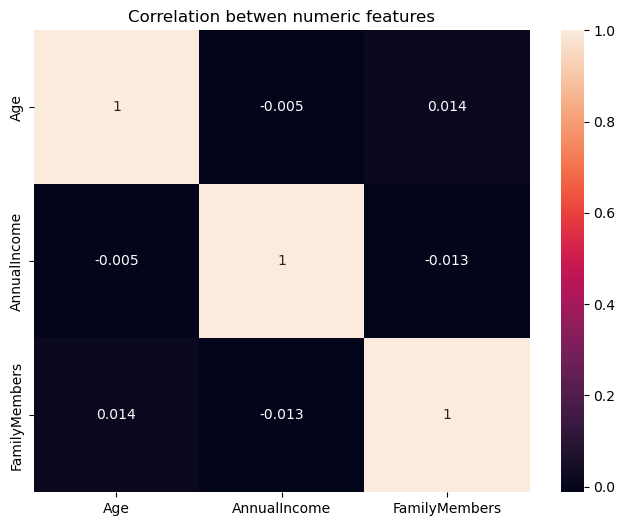

<IPython.core.display.Javascript object>

In [27]:
insurance_df[["Age", "AnnualIncome", "FamilyMembers"]].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(insurance_df[["Age", "AnnualIncome", "FamilyMembers"]].corr(), annot=True)
plt.title("Correlation betwen numeric features")
plt.show()

There is no correlation between the numeric variables.

### Statistical inference

In [28]:
def get_significance(p: float) -> str:
    """
    Returns a string indicating if H0 is rejected or not, comparing a given p-value to alpha (0.05).

    Args:
        p (float): The p-value from a statistical test.

    Returns:
        str: A string indicating whether to reject or fail to reject the null hypothesis.
    """
    if p <= 0.05:
        return "P value is below alpha 0.05 --> Reject H0."
    elif p > 0.05:
        return "P value is above alpha 0.05 --> Fail to reject H0"

<IPython.core.display.Javascript object>

### Indepence of categorical variables

#### Chi-Square Test of Independence:

H0: There are no relationships between the categorical variables. If you know the value of one variable, it does not help you predict the value of another variable.<br>

HA: There are relationships between the categorical variables. Knowing the value of one variable does help you predict the value of another variable.

In [29]:
contingency_table = pd.crosstab(
    [
        insurance_df["EmployedInGovernment"],
        insurance_df["GraduateOrNot"],
        insurance_df["ChronicDiseases"],
        insurance_df["FrequentFlyer"],
        insurance_df["EverTravelledAbroad"],
    ],
    insurance_df["TravelInsurance"],
)
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p_value}")
get_significance(p_value)

Chi-square statistic: 161.79905874761832
P-value: 5.451583934740718e-22


'P value is below alpha 0.05 --> Reject H0.'

<IPython.core.display.Javascript object>

#### Which combination of categorical variables attracts most insurance buyers?

In [30]:
contingency_table_normalized = pd.crosstab(
    [
        insurance_df["EmployedInGovernment"],
        insurance_df["GraduateOrNot"],
        insurance_df["ChronicDiseases"],
        insurance_df["FrequentFlyer"],
        insurance_df["EverTravelledAbroad"],
    ],
    insurance_df["TravelInsurance"],
    normalize="all",
)
contingency_table_normalized.sort_values(
    by=contingency_table.columns[-1], ascending=False
)[:5]

TravelInsurance                                                                              0  \
EmployedInGovernment GraduateOrNot ChronicDiseases FrequentFlyer EverTravelledAbroad             
1                    1             0               0             0                    0.145717   
0                    1             0               0             0                    0.091273   
1                    1             1               0             0                    0.081665   
                                   0               0             1                    0.015212   
                                                   1             1                    0.007206   

TravelInsurance                                                                              1  
EmployedInGovernment GraduateOrNot ChronicDiseases FrequentFlyer EverTravelledAbroad            
1                    1             0               0             0                    0.073659  
0                    1             0               0             0                    0.040833  
1                    1             1               0             0                    0.035228  
                                   0               0             1                    0.033627  
                                                   1             1                    0.031225

<IPython.core.display.Javascript object>

People who are employed in Government and graduates, not Frequent flyers and never travelled abroad tends to buy the insurance the most (1st and 3rd place). 

#### Income comparison between Graduated and not people

In [31]:
non_graduated_income = insurance_df[insurance_df["GraduateOrNot"] == 0]["AnnualIncome"]
graduated_income = insurance_df[insurance_df["GraduateOrNot"] == 1]["AnnualIncome"]

<IPython.core.display.Javascript object>

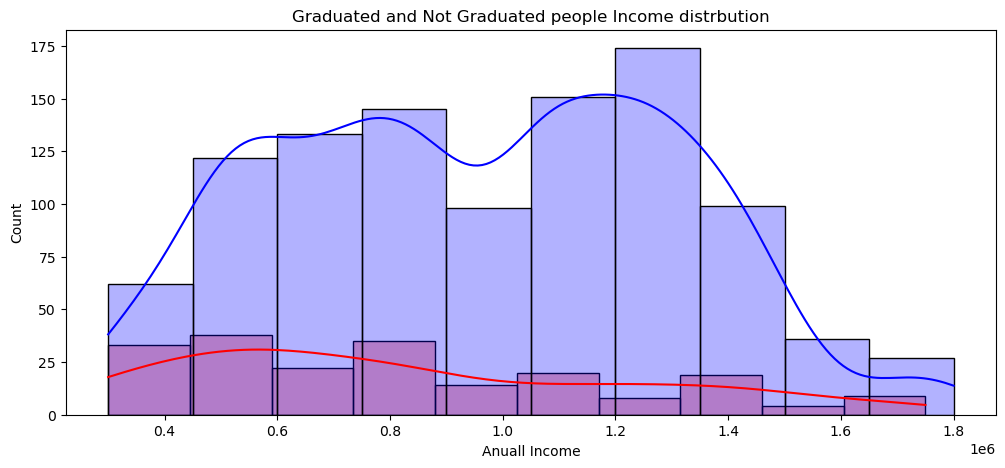

Non_graduated skewness: 0.583
Graduated skewness: 0.080


<IPython.core.display.Javascript object>

In [32]:
fig, ax = plt.subplots(figsize=(12, 5))

sns.histplot(data=non_graduated_income, bins=10, kde=True, ax=ax, color="r", alpha=0.3)
sns.histplot(data=graduated_income, bins=10, kde=True, ax=ax, color="b", alpha=0.3)
ax.set_xlabel("Anuall Income")
ax.set_ylabel("Count")
ax.set_title("Graduated and Not Graduated people Income distrbution")
plt.show()

non_graduated_skewness = stats.skew(non_graduated_income)
graduated_skewness = stats.skew(graduated_income)
print(
    f"Non_graduated skewness: {non_graduated_skewness:.3f}\nGraduated skewness: {graduated_skewness:.3f}"
)

Since non-graduated people group do not follow normal distribution, I am going to use non-parametric Mann-Whitney U Test.


H0: Graduated and Not Graduated people do not have significance differnece in anual Income<br>
HA: Graduated and Not Graduated people do have significance differnece in anual Income

In [33]:
statistic, pvalue = mannwhitneyu(graduated_income, non_graduated_income)
get_significance(pvalue)

'P value is below alpha 0.05 --> Reject H0.'

<IPython.core.display.Javascript object>

#### Income comparison between different age groups

In [34]:
# Defining age groups and taking income data for the groups
income25_28 = insurance_df[(insurance_df["Age"] >= 25) & (insurance_df["Age"] <= 28)][
    "AnnualIncome"
].to_list()
income29_31 = insurance_df[(insurance_df["Age"] >= 29) & (insurance_df["Age"] <= 31)][
    "AnnualIncome"
].to_list()
income32_35 = insurance_df[(insurance_df["Age"] >= 32) & (insurance_df["Age"] <= 35)][
    "AnnualIncome"
].to_list()

<IPython.core.display.Javascript object>

In [35]:
income25_28_skewness = stats.skew(income25_28)
income29_31_skewness = stats.skew(income29_31)
income32_35_skewness = stats.skew(income32_35)
print(
    f"Age group 25-28 skewness: {non_graduated_skewness:.3f}\nAge group 29-31 skewness: {graduated_skewness:.3f}\nAge group 32-35 skewness: {graduated_skewness:.3f}"
)

Age group 25-28 skewness: 0.583
Age group 29-31 skewness: 0.080
Age group 32-35 skewness: 0.080


<IPython.core.display.Javascript object>

The age group 25-28 do not follow a normal distribution. Therefore I will use non-parametric Kruskal Wallis test to compare the annual income between the age groups.

#### Kruskal Wallis test

##### Hypotheses

H0: There is no signifficant difference between age groups' anuall income<br>
HA: There is signifficant difference between age groups' anuall income

Alpha: 0.05

In [36]:
model = stats.kruskal(income25_28, income29_31, income32_35)
get_significance(model.pvalue)

'P value is above alpha 0.05 --> Fail to reject H0'

<IPython.core.display.Javascript object>

We found out that in general, looking at whole dataset, there is no significant differnce between the age groups when comparing their annual income. I will use post-hoc Dunn's test to check the results by looking group-by-group.

#### Dunn's test

H0: There is no signifficant difference between age groups' annual income<br>
HA: There is signifficant difference between age groups' annual income

Alpha: 0.05

In [37]:
data = [income25_28, income29_31, income32_35]
names = ["income25_28", "income29_31", "income32_35"]

dunn_test_b = sph.posthoc_dunn(data)
dunn_test_b.columns = names
dunn_test_b.index = names

<IPython.core.display.Javascript object>

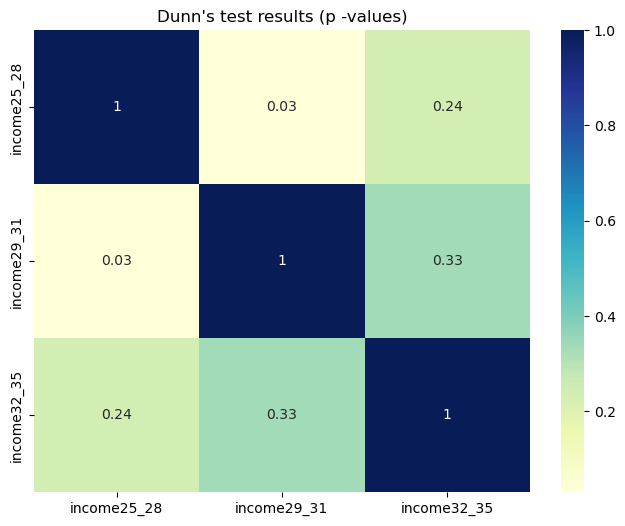

<IPython.core.display.Javascript object>

In [38]:
plt.figure(figsize=(8, 6))
sns.heatmap(dunn_test_b, annot=True, cmap="YlGnBu")
plt.title("Dunn's test results (p -values)")
plt.show()

From received results we can state, that only for age group 25-28 and 29-31 there is a significant difference in annual income.

### Machine learning models to predict the TravelInsurance column

##### We will compare the following models:
Logistic Regression<br>
Decision Tree<br>
Random Forest<br>
SVM<br>
KNN

In [39]:
classifiers = [
    ("Logistic Regression", LogisticRegression()),
    ("Decision Tree", DecisionTreeClassifier()),
    ("Random Forest", RandomForestClassifier(n_estimators=100, random_state=42)),
    ("SVM", SVC(probability=True)),
    ("KNN", KNeighborsClassifier(n_neighbors=3)),
]

<IPython.core.display.Javascript object>

In [40]:
def classifiers_roc_curves(
    classifiers: list,
    X_train: pd.DataFrame,
    X_test: pd.DataFrame,
    y_train: pd.Series,
    y_test: pd.Series,
) -> None:
    """
    Plot ROC curves for multiple classifiers using test data.

    Args:
        classifiers (list): List of tuples containing classifier names and instances.
        X_train (pd.DataFrame): Training data features.
        X_test (pd.DataFrame): Test data features.
        y_train (pd.Series): Training data target labels.
        y_test (pd.Series): Test data target labels.

    Returns:
        None
    """

    roc_traces = []
    for name, clf in classifiers:
        clf.fit(X_train, y_train)
        y_score = clf.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        roc_traces.append(
            go.Scatter(x=fpr, y=tpr, mode="lines", name=f"{name} (AUC = {roc_auc:.2f})")
        )

    roc_traces.append(
        go.Scatter(
            x=[0, 1],
            y=[0, 1],
            mode="lines",
            name="Random Chance",
            line=dict(color="gray", dash="dash"),
        )
    )

    layout = go.Layout(
        title="Receiver Operating Characteristic (ROC) Curves",
        xaxis=dict(title="False Positive Rate"),
        yaxis=dict(title="True Positive Rate"),
        showlegend=True,
        legend=dict(x=1, y=0, xanchor="right", yanchor="bottom"),
        width=900,
        height=900,
    )

    fig = go.Figure(data=roc_traces, layout=layout)
    fig.show()

<IPython.core.display.Javascript object>

In [41]:
feature_names = [
    "Age",
    "EmployedInGovernment",
    "GraduateOrNot",
    "AnnualIncome",
    "FamilyMembers",
    "ChronicDiseases",
    "FrequentFlyer",
    "EverTravelledAbroad",
]

<IPython.core.display.Javascript object>

In [42]:
ml_insurance_df = insurance_df.copy()

<IPython.core.display.Javascript object>

#### Separating labels and predictors

In [43]:
labels = ml_insurance_df["TravelInsurance"]
predictors = ml_insurance_df.drop("TravelInsurance", axis="columns")

<IPython.core.display.Javascript object>

#### Resampling the data to make it balanced (Under sampling)

In [44]:
def plot_pie_distribution(var: pd.Series) -> None:
    """
    Plot a pie chart to visualize the distribution of labels in a variable.

    Args:
        var (pd.Series): The Pandas Series containing the labels to be visualized.

    Returns:
        None
    """
    ax = var.value_counts().plot.pie(autopct="%.2f")
    _ = ax.set_title("Distribution of labels")
    plt.show()

<IPython.core.display.Javascript object>

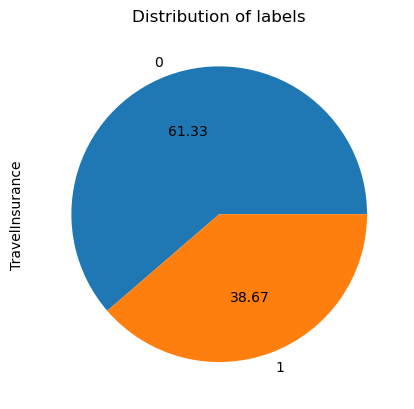

<IPython.core.display.Javascript object>

In [45]:
plot_pie_distribution(labels)

In [46]:
rus = RandomUnderSampler(sampling_strategy=1)
predictors_rus, labels_rus = rus.fit_resample(predictors, labels)

<IPython.core.display.Javascript object>

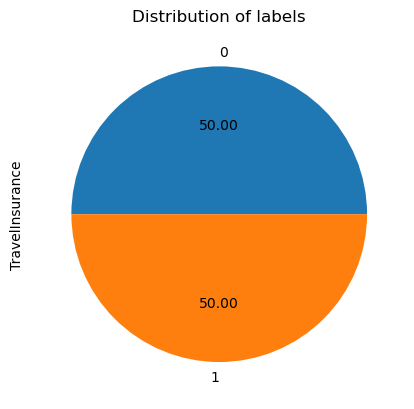

<IPython.core.display.Javascript object>

In [47]:
plot_pie_distribution(labels_rus)

#### Creating test and train datasets.

In [48]:
X_train, X_test, y_train, y_test = train_test_split(
    predictors_rus, labels_rus, test_size=0.2, random_state=42, stratify=labels_rus
)

<IPython.core.display.Javascript object>

#### Data Normalization / Choosing a scaler

In [49]:
numeric_columns = ["Age", "AnnualIncome", "FamilyMembers"]

<IPython.core.display.Javascript object>

##### Unscaled data

In [50]:
classifiers_roc_curves(classifiers, X_train, X_test, y_train, y_test)

<IPython.core.display.Javascript object>

##### MinMaxScaler

In [51]:
X_train_minmax_sclr = X_train.copy()
X_test_minmax_sclr = X_test.copy()


X_train_minmax_sclr[numeric_columns] = MinMaxScaler().fit_transform(
    X_train_minmax_sclr[numeric_columns]
)
X_test_minmax_sclr[numeric_columns] = MinMaxScaler().fit_transform(
    X_test_minmax_sclr[numeric_columns]
)

<IPython.core.display.Javascript object>

In [52]:
classifiers_roc_curves(
    classifiers, X_train_minmax_sclr, X_test_minmax_sclr, y_train, y_test
)

<IPython.core.display.Javascript object>

##### MaxAbsScaler

In [53]:
X_train_maxabs_sclr = X_train.copy()
X_test_maxabs_sclr = X_test.copy()

X_train_maxabs_sclr[numeric_columns] = MaxAbsScaler().fit_transform(
    X_train_maxabs_sclr[numeric_columns]
)

X_test_maxabs_sclr[numeric_columns] = MaxAbsScaler().fit_transform(
    X_test_maxabs_sclr[numeric_columns]
)

<IPython.core.display.Javascript object>

In [54]:
classifiers_roc_curves(
    classifiers, X_train_minmax_sclr, X_test_maxabs_sclr, y_train, y_test
)

<IPython.core.display.Javascript object>

##### Standard Scaler

In [55]:
X_train_standard_sclr = X_train.copy()
X_test_standard_sclr = X_test.copy()

X_train_standard_sclr[numeric_columns] = StandardScaler().fit_transform(
    X_train_standard_sclr[numeric_columns]
)
X_test_standard_sclr[numeric_columns] = StandardScaler().fit_transform(
    X_test_standard_sclr[numeric_columns]
)

<IPython.core.display.Javascript object>

In [56]:
classifiers_roc_curves(
    classifiers, X_train_standard_sclr, X_test_standard_sclr, y_train, y_test
)

<IPython.core.display.Javascript object>

##### Overview of models with normalized data without any further modifications

Standard scaler overall for all models provides the best score. We are going to use it for further analysis. The best performing models are Decision Tree and SVM. The worst ones - KNN and Logistic regression.

Lets see if hyperparameter tuning will help to improve the models.

In [57]:
X_train = X_train_standard_sclr
X_test = X_test_standard_sclr

<IPython.core.display.Javascript object>

#### Hyperparameter tuning

In [58]:
def hyper_param_rf(X_train, y_train):
    param_grid_rf = {
        "n_estimators": [10, 50, 100, 200],
        "max_depth": [None, 1, 2, 3, 5, 7],
        "min_samples_split": [2, 5, 8, 10],
        "min_samples_leaf": [8, 10, 12],
        "max_features": [1, 3, 5, 7],
    }

    grid_search_rf = GridSearchCV(
        estimator=RandomForestClassifier(random_state=42),
        param_grid=param_grid_rf,
        scoring="roc_auc",
        cv=5,
    )

    grid_search_rf.fit(X_train, y_train)
    return grid_search_rf

<IPython.core.display.Javascript object>

In [59]:
def hyper_param_dt(X_train, y_train):
    param_grid_dt = {
        "max_depth": [None, 1, 2, 3, 5],
        "min_samples_split": [2, 5, 8, 10],
        "min_samples_leaf": [2, 5, 8, 10],
    }

    grid_search_dt = GridSearchCV(
        estimator=DecisionTreeClassifier(),
        param_grid=param_grid_dt,
        scoring="roc_auc",
        cv=5,
    )
    grid_search_dt.fit(X_train, y_train)

    return grid_search_dt

<IPython.core.display.Javascript object>

In [60]:
def hyper_param_svm(X_train, y_train):
    param_grid_svm = {
        "C": [0.1, 0.2, 0.5, 1, 10],
        "kernel": ["linear", "rbf", "sigmoid"],
        "gamma": ["scale", "auto"] + [0.1, 1, 10],
    }
    grid_search_svm = GridSearchCV(
        estimator=SVC(probability=True), param_grid=param_grid_svm, cv=5
    )

    grid_search_svm.fit(X_train, y_train)
    return grid_search_svm

<IPython.core.display.Javascript object>

In [61]:
def hyper_param_knn(X_train, y_train):
    warnings.filterwarnings("ignore", category=FutureWarning)

    param_grid_knn = {
        "n_neighbors": [3, 5, 7, 9, 11],
        "weights": ["uniform", "distance"],
        "p": [1, 2],  # 1 for Manhattan distance, 2 for Euclidean distance
    }
    grid_search_knn = GridSearchCV(
        estimator=KNeighborsClassifier(), param_grid=param_grid_knn, cv=5
    )
    grid_search_knn.fit(X_train, y_train)
    return grid_search_knn

<IPython.core.display.Javascript object>

##### For Random Forest

In [62]:
model_rf = hyper_param_rf(X_train, y_train)
best_model_rf = model_rf.best_estimator_

<IPython.core.display.Javascript object>

##### For Decision Tree

In [63]:
model_dt = hyper_param_dt(X_train, y_train)
best_model_dt = model_dt.best_estimator_

<IPython.core.display.Javascript object>

##### For SVM

In [64]:
model_svm = hyper_param_svm(X_train, y_train)
best_model_svm = model_svm.best_estimator_

<IPython.core.display.Javascript object>

##### For KNN

In [65]:
model_knn = hyper_param_knn(X_train, y_train)
best_model_knn = model_knn.best_estimator_

<IPython.core.display.Javascript object>

In [66]:
classifiers_hyper_parameted = [
    ("Logistic Regression", LogisticRegression()),
    ("Decision Tree", best_model_dt),
    ("Random Forest", best_model_rf),
    ("SVM", best_model_svm),
    ("KNN", best_model_knn),
]

classifiers_roc_curves(classifiers_hyper_parameted, X_train, X_test, y_train, y_test)

<IPython.core.display.Javascript object>

After doing hyperparamet tuning, decision tree AUC has impoved from 0.66 to 0.68. Random Forest has improved from 63 to 68, and KNN model improved the most from 61-67.

Let's check if we would ensemble 3 best performing models, we would get a better results.

#### Model Ensembling

In [67]:
classifiers_voting_class = [
    ("Decision Tree", best_model_dt),
    ("Random Forest", best_model_rf),
    ("KNN", best_model_knn),
]

combined_model = VotingClassifier(estimators=classifiers_voting_class, voting="soft")

classifiers_hyper_parameted_final = [
    ("Logistic Regression", LogisticRegression()),
    ("Decision Tree", best_model_dt),
    ("Random Forest", best_model_rf),
    ("SVM", best_model_svm),
    ("KNN", best_model_knn),
    ("Combined", combined_model),
]

classifiers_roc_curves(
    classifiers_hyper_parameted_final, X_train, X_test, y_train, y_test
)

<IPython.core.display.Javascript object>

#### Interpreting results

A combined model did performed equally to KNN and Decision Tree. However, the Random Forest model still performs the best at correctly predicting 68% of the values.

#### Random Forest

In [68]:
def class_report_confusion_matrix(model, X_train, X_test, y_train, y_test):
    """
    Generate a classification report and display a normalized confusion matrix for a given model's predictions.

    Parameters:
    model: The trained classification model.
    X_train: Training data features.
    X_test: Test data features.
    y_train: Training data labels.
    y_test: Test data labels.

    Returns:
    None
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    report = classification_report(y_test, y_pred)
    print("Classification Report:")
    print(report)

    plt.figure()
    cm = ConfusionMatrixDisplay.from_estimator(
        model, X_test, y_test, cmap=plt.cm.Blues, normalize="true"
    )
    plt.title("Confusion Matrix (Normalized)")
    plt.show()

<IPython.core.display.Javascript object>

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.91      0.75        97
           1       0.84      0.49      0.62        97

    accuracy                           0.70       194
   macro avg       0.74      0.70      0.69       194
weighted avg       0.74      0.70      0.69       194



<Figure size 640x480 with 0 Axes>

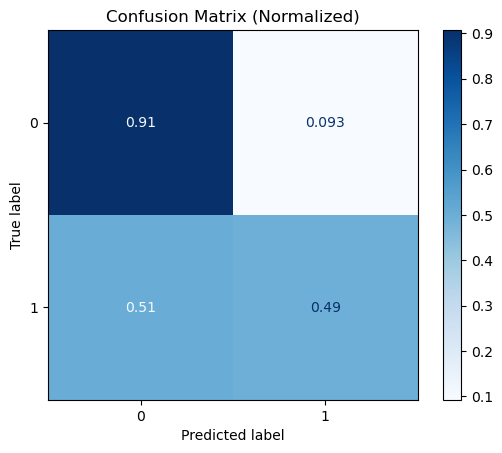

<IPython.core.display.Javascript object>

In [69]:
class_report_confusion_matrix(best_model_rf, X_train, X_test, y_train, y_test)

Precision:<br>
When the model predicts no travel insurance (class 0), it is correct 64% of the time, and when it predicts travel insurance (class 1), it is correct 74% of the time.

Recall:<br>
The model captures 80% of the actual instances of no travel insurance (class 0) and only 56% of the actual instances of travel insurance (class 1).

The overall accuracy of the model is 68%.

### Final findings

People who works in Private Sector-Self-Employed / Frequent flyers / Ever travelled abroad / purchases travel insurance tend to have a higher Annual Income.

Half frequent flyers and majority of travelled abroad people purchases Travel Insurance.


Overall only 38.7% of people in this dataset purchases Travel Insurance. the highest proportion of these people are in age 25, 33-35. 

In this dataset people most frequently have 3-5 family members. What is surprising, that only minority of people are in the fammily of 2.

People with family members 3-7 by looking at the median gets almost the same annual income (900K-925K). By looking at median, the lowest annual income is when Family Members equals to 8 (750K), and the highest - Family Members equals to 9 (1M).

In general, people who are graduates and do not have Chronic diseases, are not frequent flyers and never travelled abroad buys the insurance the most.

From received results we can state, that only for age group 25-28 and 29-31 there is a significant difference in annual income.

We received the best model results when using Standard Scaler.

After doing hyperparamet tuning, decision tree AUC has impoved from 0.66 to 0.68. Random Forest has improved from 63 to 68, and KNN model improved the most from 61-67.

Model ensembling of 3 best performing models (AUC: 67, didn't receive the better score than Random Forest (AUC:68).

Random Forest model captures 80% of the actual instances of no travel insurance (class 0) and only 56% of the actual instances of travel insurance (class 1). When the model predicts no travel insurance (class 0), it is correct 64% of the time, and when it predicts travel insurance (class 1), it is correct 74% of the time. The overall accuracy of the model is 68%.

### What could be improved?


Try Random search for hyperparameter tuning<br>
Feature engineering<br>
Try not only undersampling, but oversampling or other techniques to work with inbalanced data. <br>